# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load the Dataset

In [2]:
orders = pd.read_csv("Datasets/olist_orders_dataset.csv")
reviews = pd.read_csv("Datasets/olist_order_reviews_dataset.csv")
order_items = pd.read_csv("Datasets/olist_order_items_dataset.csv")
products = pd.read_csv("Datasets/olist_products_dataset.csv")
customers = pd.read_csv("Datasets/olist_customers_dataset.csv")
sellers = pd.read_csv("Datasets/olist_sellers_dataset.csv")

# Merging the Datasets

In [3]:
# Merge orders with reviews to get review scores
df = orders.merge(reviews, on="order_id", how="left")

# Merge with order_items to get product & seller details
df = df.merge(order_items, on="order_id", how="left")

# Merge with products dataset to get category info
df = df.merge(products, on="product_id", how="left")

# Merge with customers dataset to get customer location
df = df.merge(customers, on="customer_id", how="left")

# Merge with sellers dataset to get seller location
df = df.merge(sellers, on="seller_id", how="left")

print(df.columns)

# Keep only necessary columns
df = df[[
    "order_id", "review_score", "order_purchase_timestamp",
    "order_delivered_customer_date", "order_estimated_delivery_date",
    "product_category_name", "price", "freight_value",
    "customer_state", "seller_state"
]]

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state'],
      dtype='object')


In [4]:
df.head()

,order_id,review_score,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,price,freight_value,customer_state,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,4.0,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,utilidades_domesticas,29.99,8.72,SP,SP
1,53cdb2fc8bc7dce0b6741e2150273451,4.0,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,perfumaria,118.70,22.76,BA,SP
2,47770eb9100c2d0c44946d9cf07ec65d,5.0,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,automotivo,159.90,19.22,GO,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,5.0,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15 00:00:00,pet_shop,45.00,27.20,RN,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,5.0,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26 00:00:00,papelaria,19.90,8.72,SP,SP


# Feature Engineering

## Convert timestamps to datetime format

In [5]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])

## Creating features 
features like "delivery_time", "delay_status" and "price_range" are created

In [6]:
# Calculate delivery time (in days)
df["delivery_time"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days

# Calculate delivery delay (difference between estimated and actual delivery)
df["delivery_delay"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days
df["delivery_on_time"] = df["delivery_delay"].apply(lambda x: 1 if x <= 0 else 0)

In [7]:
# Fill missing values
df.fillna({"delivery_time": df["delivery_time"].median(), "delivery_delay": 0}, inplace=True)
df.dropna(inplace=True)  # Drop rows with missing review scores

In [8]:
# Categorize product price into bins
df["price_category"] = pd.cut(df["price"], bins=[0, 50, 150, 500, 1000, 5000], labels=["Very Low", "Low", "Medium", "High", "Very High"])

In [9]:
# Convert categorical variables
df["product_category_name"] = df["product_category_name"].fillna("unknown")
df["customer_state"] = df["customer_state"].fillna("unknown")
df["seller_state"] = df["seller_state"].fillna("unknown")
df["price_category"] = df["price_category"].astype(str)

In [10]:
df.head()

,order_id,review_score,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,price,freight_value,customer_state,seller_state,delivery_time,delivery_delay,delivery_on_time,price_category
0,e481f51cbdc54678b7cc49136f2d6af7,4.0,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,utilidades_domesticas,29.99,8.72,SP,SP,8.0,-8.0,1,Very Low
1,53cdb2fc8bc7dce0b6741e2150273451,4.0,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,perfumaria,118.70,22.76,BA,SP,13.0,-6.0,1,Low
2,47770eb9100c2d0c44946d9cf07ec65d,5.0,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,automotivo,159.90,19.22,GO,SP,9.0,-18.0,1,Medium
3,949d5b44dbf5de918fe9c16f97b45f8a,5.0,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,pet_shop,45.00,27.20,RN,MG,13.0,-13.0,1,Very Low
4,ad21c59c0840e6cb83a9ceb5573f8159,5.0,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,papelaria,19.90,8.72,SP,SP,2.0,-10.0,1,Very Low


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108479 entries, 0 to 114091
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       108479 non-null  object        
 1   review_score                   108479 non-null  float64       
 2   order_purchase_timestamp       108479 non-null  datetime64[ns]
 3   order_delivered_customer_date  108479 non-null  datetime64[ns]
 4   order_estimated_delivery_date  108479 non-null  datetime64[ns]
 5   product_category_name          108479 non-null  object        
 6   price                          108479 non-null  float64       
 7   freight_value                  108479 non-null  float64       
 8   customer_state                 108479 non-null  object        
 9   seller_state                   108479 non-null  object        
 10  delivery_time                  108479 non-null  float64       
 11  deliv

# Exploratory Data Analysis (EDA)

## Distribution of Review Scores

C:\Users\bhand\AppData\Local\Temp\ipykernel_20884\3558395553.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["review_score"], palette="viridis")


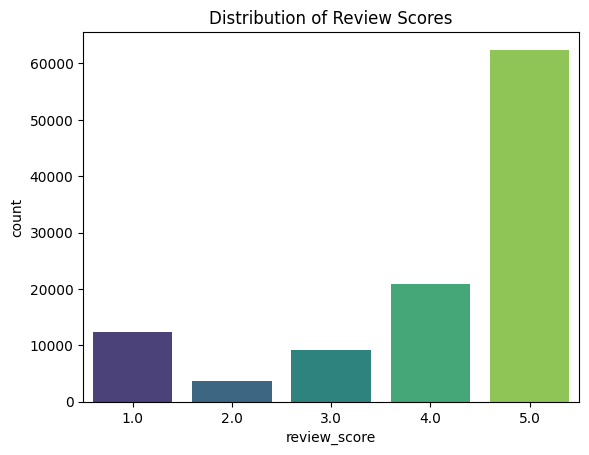

In [12]:
sns.countplot(x=df["review_score"], palette="viridis")
plt.title("Distribution of Review Scores")
plt.show()

## Impact of delivery delay on review score

C:\Users\bhand\AppData\Local\Temp\ipykernel_20884\2707564645.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["review_score"], y=df["delivery_time"], palette="coolwarm")


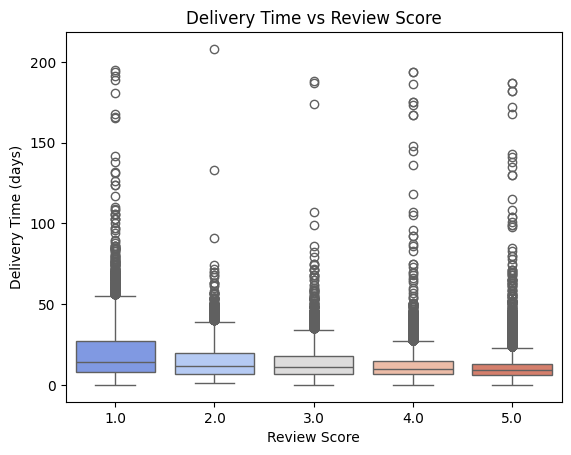

In [13]:
sns.boxplot(x=df["review_score"], y=df["delivery_time"], palette="coolwarm")
plt.title("Delivery Time vs Review Score")
plt.xlabel("Review Score")
plt.ylabel("Delivery Time (days)")
plt.show()

## Impact of Delivery Delays

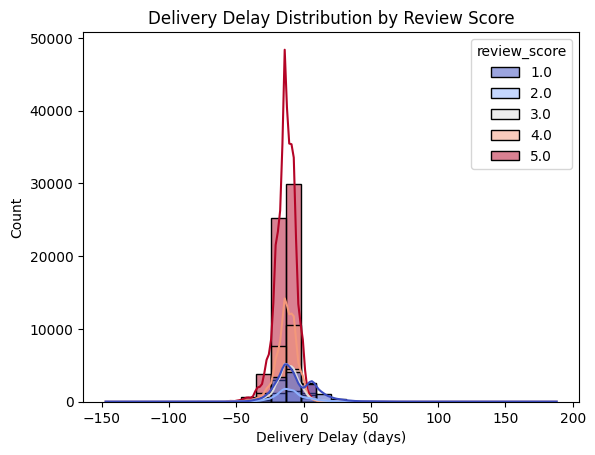

In [14]:
sns.histplot(data=df, x="delivery_delay", hue="review_score", bins=30, kde=True, palette="coolwarm")
plt.title("Delivery Delay Distribution by Review Score")
plt.xlabel("Delivery Delay (days)")
plt.ylabel("Count")
plt.show()

## Top & Bottom Product Categories by Rating

C:\Users\bhand\AppData\Local\Temp\ipykernel_20884\2043831533.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_categories.index, x=top_categories.values, palette="Greens")
C:\Users\bhand\AppData\Local\Temp\ipykernel_20884\2043831533.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=bottom_categories.index, x=bottom_categories.values, palette="Reds")


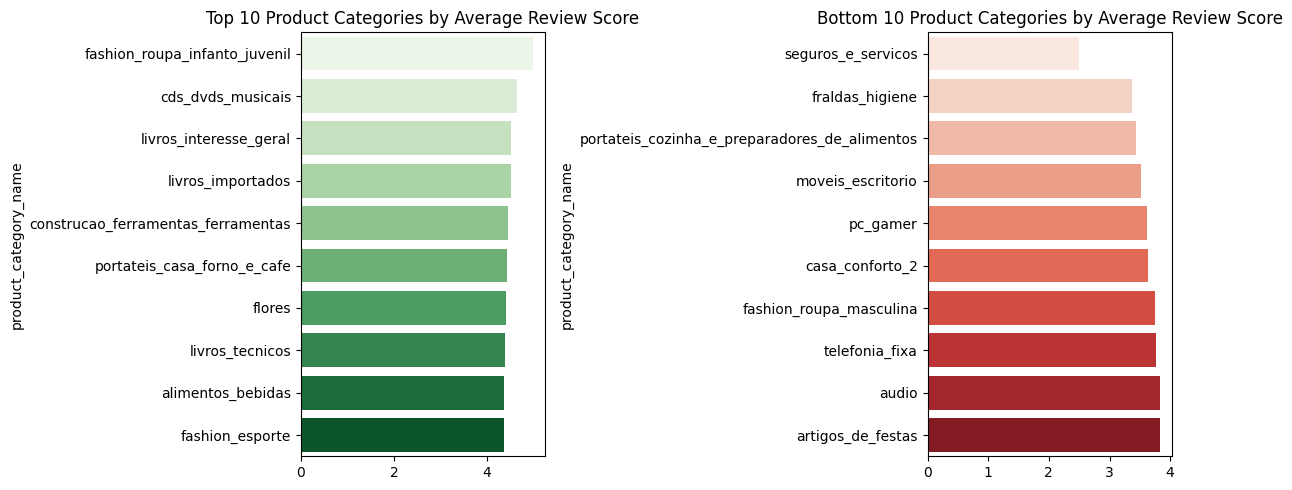

In [15]:
top_categories = df.groupby("product_category_name")["review_score"].mean().sort_values(ascending=False).head(10)
bottom_categories = df.groupby("product_category_name")["review_score"].mean().sort_values(ascending=True).head(10)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(y=top_categories.index, x=top_categories.values, palette="Greens")
plt.title("Top 10 Product Categories by Average Review Score")

plt.subplot(1,2,2)
sns.barplot(y=bottom_categories.index, x=bottom_categories.values, palette="Reds")
plt.title("Bottom 10 Product Categories by Average Review Score")

plt.tight_layout()
plt.show()

## Effect of Order Price on Review Score

C:\Users\bhand\AppData\Local\Temp\ipykernel_20884\2377719291.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["review_score"], y=df["price"], palette="magma")


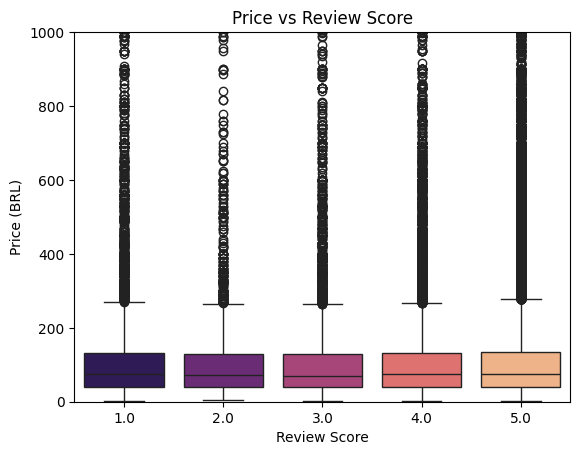

In [16]:
sns.boxplot(x=df["review_score"], y=df["price"], palette="magma")
plt.title("Price vs Review Score")
plt.ylim(0, 1000)  # Remove extreme outliers for better visibility
plt.xlabel("Review Score")
plt.ylabel("Price (BRL)")
plt.show()

## Seller State vs Review Score

C:\Users\bhand\AppData\Local\Temp\ipykernel_20884\2313767554.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seller_ratings.index, y=seller_ratings.values, palette="coolwarm")


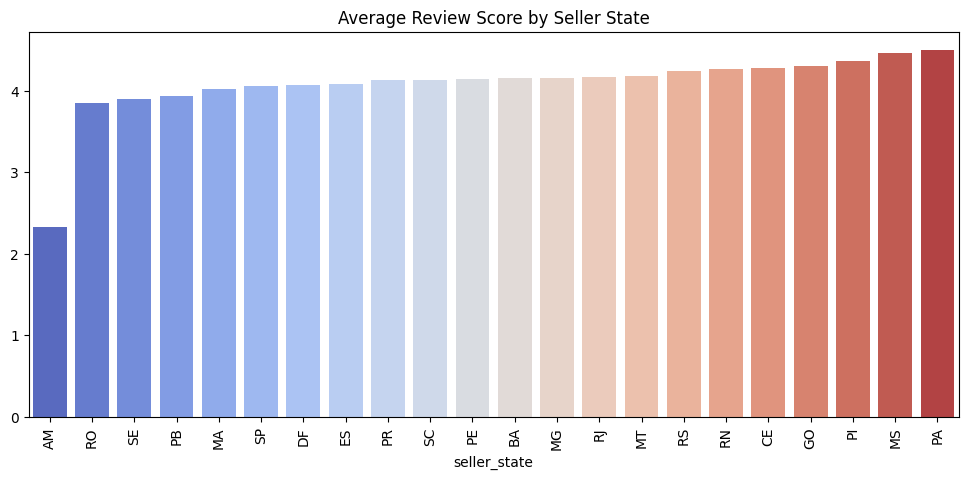

In [17]:
seller_ratings = df.groupby("seller_state")["review_score"].mean().sort_values()

plt.figure(figsize=(12,5))
sns.barplot(x=seller_ratings.index, y=seller_ratings.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Average Review Score by Seller State")
plt.show()

## Multiple Items in an Order vs Review Score

C:\Users\bhand\AppData\Local\Temp\ipykernel_20884\2686458313.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["review_score"], y=df["num_items"], palette="Purples")


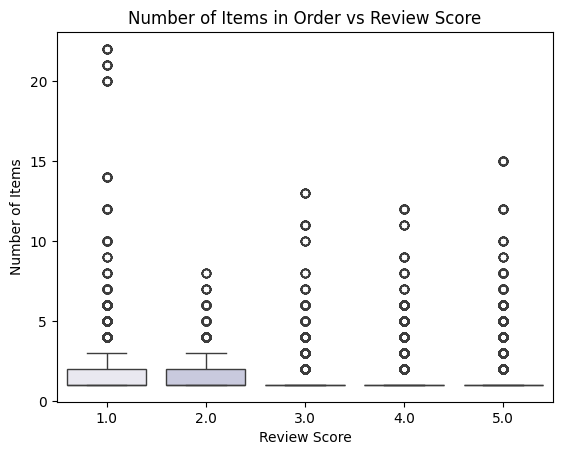

In [18]:
df["num_items"] = df.groupby("order_id")["order_id"].transform("count")

sns.boxplot(x=df["review_score"], y=df["num_items"], palette="Purples")
plt.title("Number of Items in Order vs Review Score")
plt.xlabel("Review Score")
plt.ylabel("Number of Items")
plt.show()

## Freight Cost vs Review Score

C:\Users\bhand\AppData\Local\Temp\ipykernel_20884\2814031220.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["review_score"], y=df["freight_value"], palette="Oranges")


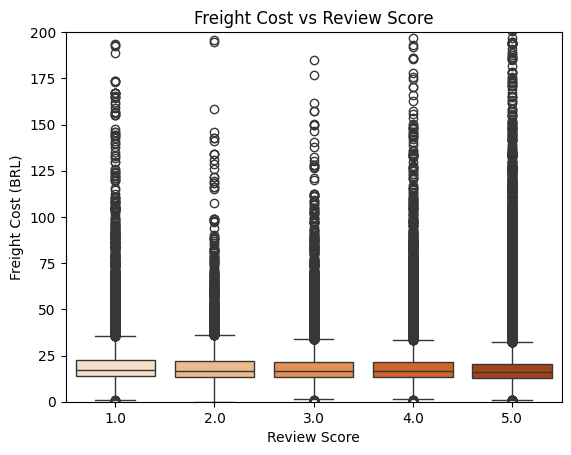

In [19]:
sns.boxplot(x=df["review_score"], y=df["freight_value"], palette="Oranges")
plt.title("Freight Cost vs Review Score")
plt.xlabel("Review Score")
plt.ylabel("Freight Cost (BRL)")
plt.ylim(0, 200)  # Remove extreme outliers
plt.show()

## Customer State vs Review Score

C:\Users\bhand\AppData\Local\Temp\ipykernel_20884\1506931978.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_ratings.index, y=customer_ratings.values, palette="viridis")


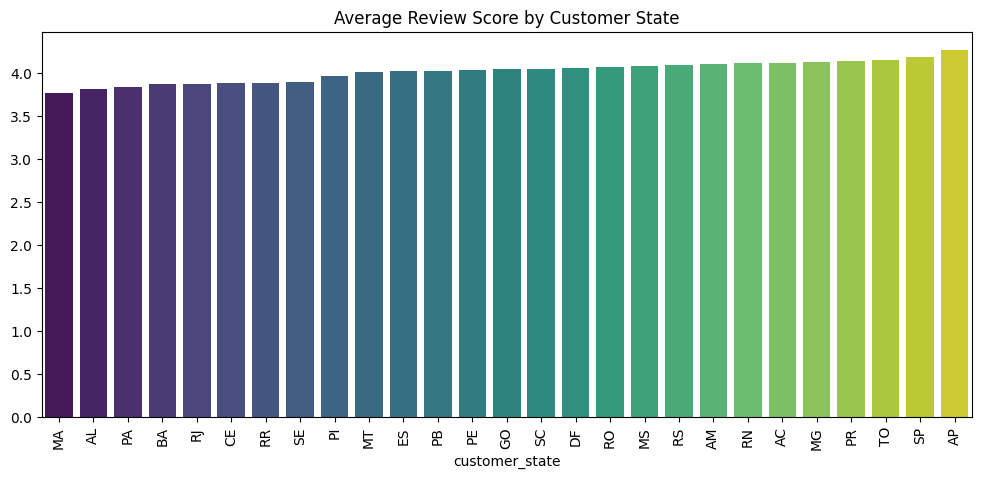

In [20]:
customer_ratings = df.groupby("customer_state")["review_score"].mean().sort_values()

plt.figure(figsize=(12,5))
sns.barplot(x=customer_ratings.index, y=customer_ratings.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Average Review Score by Customer State")
plt.show()

## Correlation Heatmap

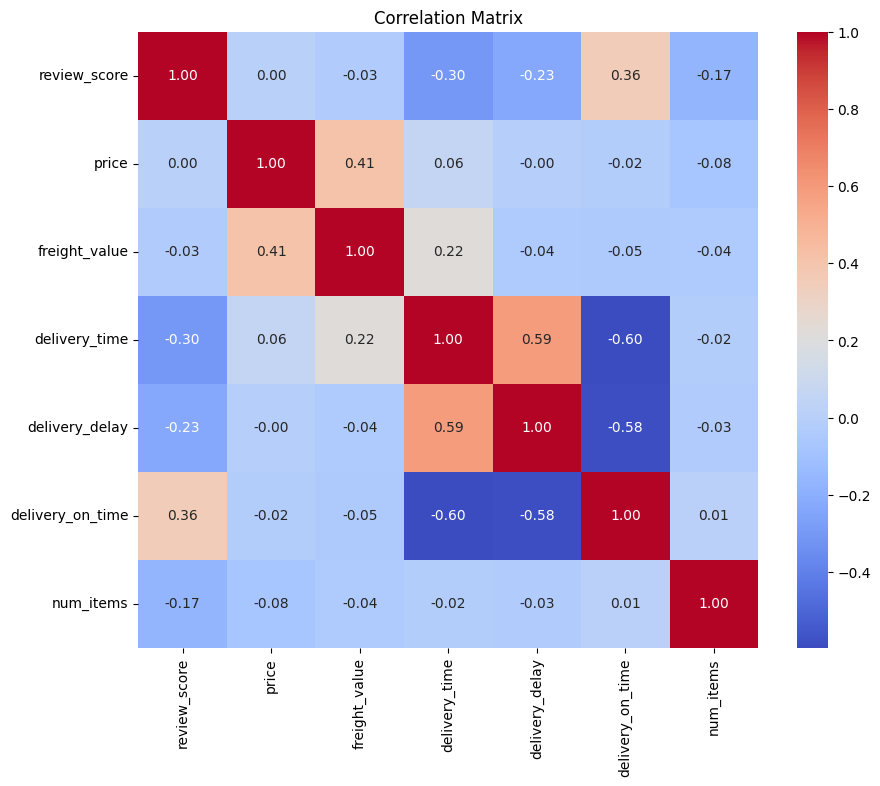

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=["number"]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Price vs Freight Value (Scatter Plot)

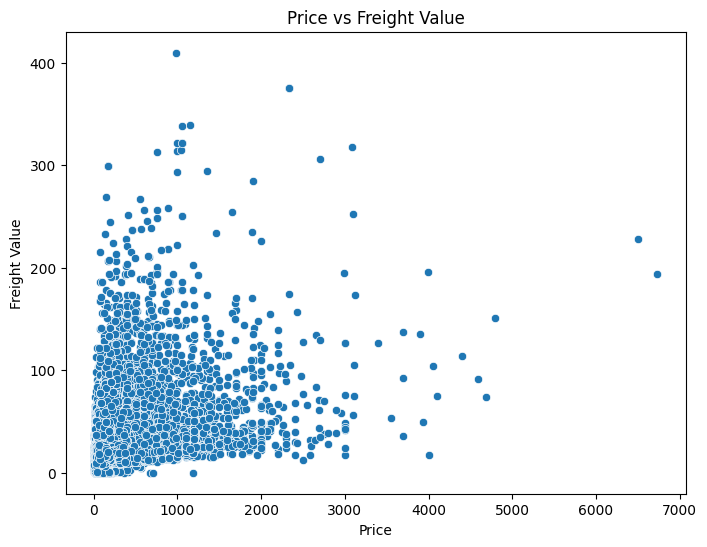

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df["price"], y=df["freight_value"])
plt.title("Price vs Freight Value")
plt.xlabel("Price")
plt.ylabel("Freight Value")
plt.show()

## Price Category vs Review Score (Bar Plot)

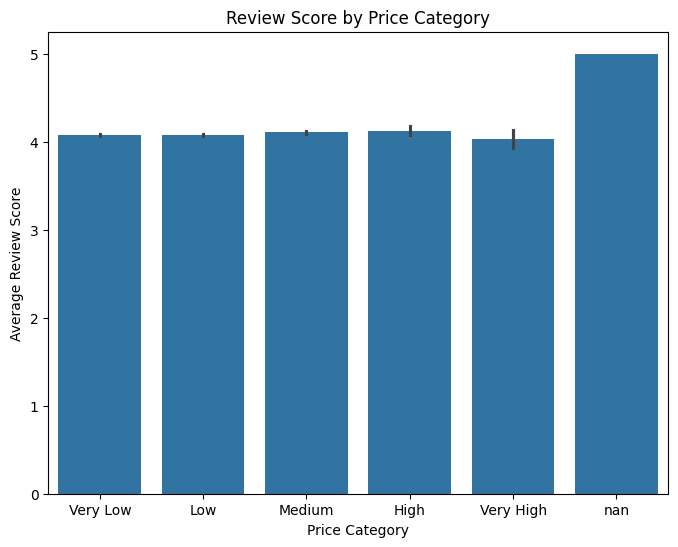

In [23]:
plt.figure(figsize=(8,6))
sns.barplot(x=df["price_category"], y=df["review_score"])
plt.title("Review Score by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Average Review Score")
plt.show()

# Preprocessing

In [24]:
print(df.columns)

Index(['order_id', 'review_score', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'product_category_name', 'price', 'freight_value', 'customer_state',
       'seller_state', 'delivery_time', 'delivery_delay', 'delivery_on_time',
       'price_category', 'num_items'],
      dtype='object')


In [25]:
df.head()


,order_id,review_score,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,price,freight_value,customer_state,seller_state,delivery_time,delivery_delay,delivery_on_time,price_category,num_items
0,e481f51cbdc54678b7cc49136f2d6af7,4.0,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,utilidades_domesticas,29.99,8.72,SP,SP,8.0,-8.0,1,Very Low,1
1,53cdb2fc8bc7dce0b6741e2150273451,4.0,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,perfumaria,118.70,22.76,BA,SP,13.0,-6.0,1,Low,1
2,47770eb9100c2d0c44946d9cf07ec65d,5.0,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,automotivo,159.90,19.22,GO,SP,9.0,-18.0,1,Medium,1
3,949d5b44dbf5de918fe9c16f97b45f8a,5.0,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,pet_shop,45.00,27.20,RN,MG,13.0,-13.0,1,Very Low,1
4,ad21c59c0840e6cb83a9ceb5573f8159,5.0,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,papelaria,19.90,8.72,SP,SP,2.0,-10.0,1,Very Low,1


In [26]:
import pandas as pd


# Define the function to categorize feedback
df['feedback_category'] = df['review_score'].apply(lambda x: 'bad' if x <= 2 else ('neutral' if x == 3 else 'good'))

print(df)

                                order_id  review_score  \
0       e481f51cbdc54678b7cc49136f2d6af7           4.0   
1       53cdb2fc8bc7dce0b6741e2150273451           4.0   
2       47770eb9100c2d0c44946d9cf07ec65d           5.0   
3       949d5b44dbf5de918fe9c16f97b45f8a           5.0   
4       ad21c59c0840e6cb83a9ceb5573f8159           5.0   
...                                  ...           ...   
114087  63943bddc261676b46f01ca7ac2f7bd8           4.0   
114088  83c1379a015df1e13d02aae0204711ab           5.0   
114089  11c177c8e97725db2631073c19f07b62           2.0   
114090  11c177c8e97725db2631073c19f07b62           2.0   
114091  66dea50a8b16d9b4dee7af250b4be1a5           5.0   

       order_purchase_timestamp order_delivered_customer_date  \
0           2017-10-02 10:56:33           2017-10-10 21:25:13   
1           2018-07-24 20:41:37           2018-08-07 15:27:45   
2           2018-08-08 08:38:49           2018-08-17 18:06:29   
3           2017-11-18 19:28:06           2

In [28]:
drop_cols = ["order_id", "order_purchase_timestamp", "order_delivered_customer_date", 
             "order_estimated_delivery_date", "review_score"]
df = df.drop(columns=drop_cols)

In [29]:
# Encoding categorical variables
label_encoders = {}
categorical_cols = ["product_category_name", "customer_state", "seller_state", "price_category"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [30]:
# Encoding target variable
target_encoder = LabelEncoder()
df["feedback_category"] = target_encoder.fit_transform(df["feedback_category"])

In [31]:
print(df.columns)

Index(['product_category_name', 'price', 'freight_value', 'customer_state',
       'seller_state', 'delivery_time', 'delivery_delay', 'delivery_on_time',
       'price_category', 'num_items', 'feedback_category'],
      dtype='object')


In [32]:
# Scaling numerical features
scaler = StandardScaler()
numerical_cols = ["price", "freight_value", "delivery_time", "delivery_delay", "num_items"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Machine Learning - Predicting Review Score

In [33]:
df.head()

,product_category_name,price,freight_value,customer_state,seller_state,delivery_time,delivery_delay,delivery_on_time,price_category,num_items,feedback_category
0,72,-0.497544,-0.716390,25,21,-0.424143,0.404489,1,4,-0.35634,1
1,62,-0.006174,0.177938,4,21,0.110597,0.602780,1,1,-0.35634,1
2,8,0.222036,-0.047555,8,21,-0.317195,-0.586964,1,2,-0.35634,1
3,63,-0.414403,0.460760,19,7,0.110597,-0.091238,1,4,-0.35634,1
4,59,-0.553434,-0.716390,25,21,-1.065831,0.206198,1,4,-0.35634,1


In [34]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [39]:
# Splitting data
X = df.drop(columns=["feedback_category"])
y = df["feedback_category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Training XGBoost Model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
model.fit(X_train, y_train)

C:\Users\bhand\AppData\Roaming\Python\Python313\site-packages\xgboost\core.py:158: UserWarning: [08:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [40]:
# Predictions
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("-----XGBOOST-----\n")
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

-----XGBOOST-----

Accuracy: 0.8106
              precision    recall  f1-score   support

           0       0.76      0.34      0.47      3196
           1       0.81      0.99      0.89     16670
           2       0.95      0.03      0.07      1830

    accuracy                           0.81     21696
   macro avg       0.84      0.45      0.48     21696
weighted avg       0.82      0.81      0.76     21696



In [41]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf_model = RandomForestClassifier(class_weight={0:2, 1:1, 2:3}, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred_rf)
print("-----RANDOM FOREST CLASSIFIER-----\n")
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_rf))

-----RANDOM FOREST CLASSIFIER-----

Accuracy: 0.8424
              precision    recall  f1-score   support

           0       0.82      0.51      0.63      3196
           1       0.85      0.98      0.91     16670
           2       0.75      0.17      0.27      1830

    accuracy                           0.84     21696
   macro avg       0.80      0.55      0.60     21696
weighted avg       0.83      0.84      0.81     21696

